In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv

HOME_DIR = 'F:/dogs-vs-cats/'

In [2]:
#load normalized data that was produced from image_prep notebook
train_dataset = np.load(HOME_DIR + 'train_dataset.npy')
train_labels = np.load(HOME_DIR + 'train_labels.npy')
valid_dataset = np.load(HOME_DIR + 'valid_dataset.npy')
valid_labels = np.load(HOME_DIR + 'valid_labels.npy')

In [3]:
image_size = 150
num_labels = 2
num_channels = 3

def reformat(dataset, labels):
    dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (labels=='cats').astype(np.float32); # set dogs to 0 and cats to 1
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)

print ('Training set', train_dataset.shape, train_labels.shape)
print ('Validation set', valid_dataset.shape, valid_labels.shape)


Training set (20000, 150, 150, 3) (20000, 2)
Validation set (5000, 150, 150, 3) (5000, 2)


In [4]:
batch_size = 64

# Input data.
tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))

# variables

#convolutions
kernel_conv1 = tf.Variable(tf.truncated_normal([3, 3, 3, 32], dtype=tf.float32, stddev=1e-1), name='weights_conv1')
biases_conv1 = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32), trainable=True, name='biases_conv1')

kernel_conv2 = tf.Variable(tf.truncated_normal([3, 3, 32, 64], dtype=tf.float32, stddev=1e-1), name='weights_conv2')
biases_conv2 = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32), trainable=True, name='biases_conv2')

kernel_conv3 = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32, stddev=1e-1), name='weights_conv3')
biases_conv3 = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32), trainable=True, name='biases_conv3')

kernel_conv4 = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32, stddev=1e-1), name='weights_conv4')
biases_conv4 = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32), trainable=True, name='biases_conv4')

kernel_conv5 = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32, stddev=1e-1), name='weights_conv5')
biases_conv5 = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32), trainable=True, name='biases_conv5')

#fully connected layers
fc1w = tf.Variable(tf.truncated_normal([25600, 64], dtype=tf.float32, stddev=1e-1), name='weights')
fc1b = tf.Variable(tf.constant(1.0, shape=[64], dtype=tf.float32), trainable=True, name='biases')

fc2w = tf.Variable(tf.truncated_normal([64, 2], dtype=tf.float32, stddev=1e-1), name='weights')
fc2b = tf.Variable(tf.constant(1.0, shape=[2], dtype=tf.float32), trainable=True, name='biases')

#used for dropout
keep_prob = tf.placeholder(tf.float32)


def model(data):
    with tf.name_scope('conv1_1') as scope:
        conv = tf.nn.conv2d(data, kernel_conv1, [1, 1, 1, 1], padding='SAME')
        out = tf.nn.bias_add(conv, biases_conv1)
        conv1_1 = tf.nn.relu(out, name=scope)
        
    # pool1
    pool1 = tf.nn.max_pool(conv1_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')

    with tf.name_scope('conv2_1') as scope:
        conv = tf.nn.conv2d(pool1, kernel_conv2, [1, 1, 1, 1], padding='SAME')
        out = tf.nn.bias_add(conv, biases_conv2)
        conv2_1 = tf.nn.relu(out, name=scope)

    # pool2
    pool2 = tf.nn.max_pool(conv2_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')

    with tf.name_scope('conv3_1') as scope:
        conv = tf.nn.conv2d(pool2, kernel_conv3, [1, 1, 1, 1], padding='SAME')
        out = tf.nn.bias_add(conv, biases_conv3)
        conv3_1 = tf.nn.relu(out, name=scope)
        
    with tf.name_scope('conv4_1') as scope:
        conv = tf.nn.conv2d(conv3_1, kernel_conv4, [1, 1, 1, 1], padding='SAME')
        out = tf.nn.bias_add(conv, biases_conv4)
        conv4_1 = tf.nn.relu(out, name=scope)
         
    # pool3
    pool3 = tf.nn.max_pool(conv4_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool4')
    
    with tf.name_scope('conv5_1') as scope:
        conv = tf.nn.conv2d(pool3, kernel_conv5, [1, 1, 1, 1], padding='SAME')
        out = tf.nn.bias_add(conv, biases_conv5)
        conv5_1 = tf.nn.relu(out, name=scope)
        
    
    # pool4
    pool4 = tf.nn.max_pool(conv5_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool5')

    # fc1
    with tf.name_scope('fc1') as scope:
        shape = int(np.prod(pool4.get_shape()[1:])) # except for batch size (the first one), multiple the dimensions
        pool4_flat = tf.reshape(pool4, [-1, shape])
        
        #dropout
        pool4_drop = tf.nn.dropout(pool4_flat, keep_prob)
        
        fc1l = tf.nn.bias_add(tf.matmul(pool4_drop, fc1w), fc1b)
        fc1 = tf.nn.relu(fc1l)
        
    
    # fc2
    with tf.name_scope('fc2') as scope:
        fc2l = tf.nn.bias_add(tf.matmul(fc1, fc2w), fc2b)

    return fc2l;

# Training computation
logits = model(tf_train_dataset)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits))

# Optimizer
learn_rate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.RMSPropOptimizer(learn_rate).minimize(loss)

# Predictions for the training, validation, and test data
train_prediction = tf.nn.softmax(logits)

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [5]:
session = tf.InteractiveSession()
init = tf.global_variables_initializer()
session.run(init)


In [6]:
num_steps = 5001

tf_valid_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
valid_prediction = tf.nn.softmax(model(tf_valid_dataset))

valid_loss_list=[]
batch_loss_list=[]
step_list=[]


for step in range(num_steps):
    
    #adjust learning rate
    lr = 10.0**(-3 - step//1000)
    
    random_batch = np.random.randint(0,len(train_labels),size=64)
    batch_data = train_dataset[random_batch]
    batch_labels = train_labels[random_batch]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 0.6, learn_rate : lr}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
        print ("Training loss at step", step, ":", l)
            
    if (step % 100 == 0):        
        step_list.append(step)
        batch_loss_list.append(l)
        
        #check accuracy on randomly selected validation data
        random_index = np.random.randint(0,len(valid_labels),size=200)
        valid_loss = session.run(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = valid_labels[random_index], logits = model(tf_valid_dataset))),
                                 feed_dict = {tf_valid_dataset : valid_dataset[random_index],
                                              keep_prob: 1.0})
        valid_loss_list.append(valid_loss)
        
print('Done')

Training loss at step 0 : 4.08639
Training loss at step 500 : 0.449781
Training loss at step 1000 : 0.46402
Training loss at step 1500 : 0.32191
Training loss at step 2000 : 0.157231
Training loss at step 2500 : 0.125294
Training loss at step 3000 : 0.131734
Training loss at step 3500 : 0.195473
Training loss at step 4000 : 0.173253
Training loss at step 4500 : 0.284062
Training loss at step 5000 : 0.256419
Done


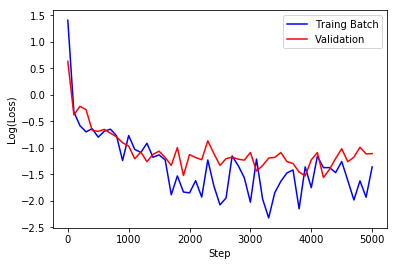

In [7]:
plt.plot(step_list, np.log(batch_loss_list), '-b', label='Traing Batch')
plt.plot(step_list, np.log(valid_loss_list), '-r', label='Validation')
plt.xlabel('Step')
plt.ylabel('Log(Loss)')
plt.legend()
plt.show()

In [8]:
def load_test_data():
    test_ids = np.load(HOME_DIR + 'test_ids.npy')
    test_dataset = np.load(HOME_DIR + 'test_dataset.npy')
    return test_dataset, test_ids


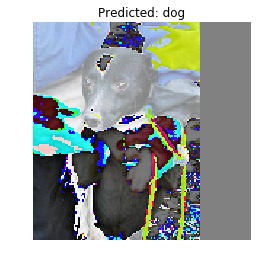

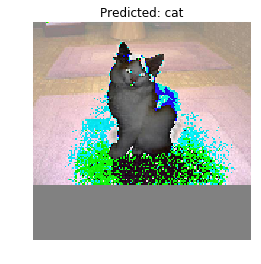

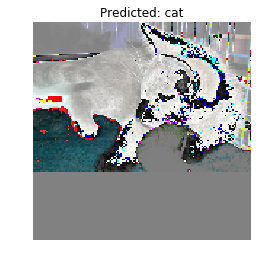

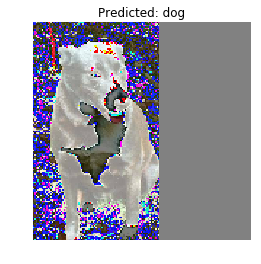

In [13]:
def show_test_samples(num):
    test_dataset, test_ids = load_test_data()
    tf_test_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    predictions=session.run(tf.nn.softmax(model(tf_test_dataset)), 
                           feed_dict = {tf_test_dataset : test_dataset[0:num], keep_prob: 1.0})
    for i in range(num):
        if predictions[i][0] > predictions[i][1]:
            label = 'dog'
        else:
            label = 'cat'
        plt.imshow(test_dataset[i], interpolation='nearest')
        plt.axis('off')
        plt.title('Predicted: ' + label)
        plt.show()
    return

show_test_samples(4)

In [ ]:
def write_output(filename):
    test_dataset, test_ids = load_test_data()
    print("Test data loaded")
    ofile=open(filename,'w',newline='')
    writer = csv.writer(ofile)
    header=["id","label"]
    writer.writerow(header)
    tf_test_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    block_size = 100
    block = 0
    while block < len(test_ids):
        step = min(block_size, len(test_ids)-block)
        prediction=session.run(tf.nn.softmax(model(tf_test_dataset)), 
                               feed_dict = {tf_test_dataset : test_dataset[block:block+step], keep_prob: 1.0})
        ids = test_ids[block:block+step]
        for j in range(len(ids)):
            writer.writerow([ids[j],prediction[j,0]])
        if block % 500 == 0:
            print(str(block)+' lines printed')
        block += block_size
    ofile.close()
    print('Done')

In [ ]:
write_output('out.csv')

In [ ]:
session.close()